In [2]:
# Some jupyter magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cases = ('run 1', 'non-BFB restart', 'ck tune', '3x nu_div')
data_dirs = {
    #'run 1': '/global/cfs/cdirs/e3sm/terai/SCREAM/DYAMOND2/Output/20201112',
    'run 1': '/global/cscratch1/sd/terai/e3sm_scratch/cori-knl/20201112.SCREAMv0dyamond2.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16/run',
    'non-BFB restart': '/global/cscratch1/sd/terai/e3sm_scratch/cori-knl/20201112.SCREAMv0dyamond2_cont.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16/run',
    'ck tune': '/global/cscratch1/sd/terai/e3sm_scratch/cori-knl/20201123.SCREAMv0dyamond2_ck_0pt1.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16/run',
    '3x nu_div': '/global/cscratch1/sd/terai/e3sm_scratch/cori-knl/20201123.SCREAMv0dyamond2_nudiv3x.SCREAM-DY2.ne1024.3072x8x16/run',
}
long_names = {
    'run 1': '20201112.SCREAMv0dyamond2.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16',
    'non-BFB restart': '20201112.SCREAMv0dyamond2_cont.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16',
    'ck tune': '20201123.SCREAMv0dyamond2_ck_0pt1.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16',
    '3x nu_div': '20201123.SCREAMv0dyamond2_nudiv3x.SCREAM-DY2.ne1024.3072x8x16',
}

In [4]:
varname = 'TREFHT'
data_dirs[cases[0]]

'/global/cscratch1/sd/terai/e3sm_scratch/cori-knl/20201112.SCREAMv0dyamond2.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16/run'

In [5]:
import xarray
from glob import glob
files = {c: sorted(glob(f'{data_dirs[c]}/{long_names[c]}.eam.h*.nc')) for c in cases}

In [6]:
from e3smplot.e3sm_utils import can_retrieve_field
files = {c: [f for f in files[c] if can_retrieve_field(f, varname)] for c in cases}

In [7]:
files

{'run 1': ['/global/cscratch1/sd/terai/e3sm_scratch/cori-knl/20201112.SCREAMv0dyamond2.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16/run/20201112.SCREAMv0dyamond2.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16.eam.h1.2020-02-02-00000.nc',
  '/global/cscratch1/sd/terai/e3sm_scratch/cori-knl/20201112.SCREAMv0dyamond2.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16/run/20201112.SCREAMv0dyamond2.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16.eam.h1.2020-02-03-00000.nc'],
 'non-BFB restart': ['/global/cscratch1/sd/terai/e3sm_scratch/cori-knl/20201112.SCREAMv0dyamond2_cont.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16/run/20201112.SCREAMv0dyamond2_cont.F2010-SCREAM-HR-DYAMOND2.ne1024pg2_r0125_oRRS18to6v3.cori-knl.1536x8x16.eam.h1.2020-02-02-00900.nc'],
 'ck tune': ['/global/cscratch1/sd/terai/e3sm_scratch/cori-knl/20201123.SCREAMv0dyamond2_ck_0pt1.F2010-SCREAM-HR-DYAM

In [8]:
from e3smplot.e3sm_utils import get_data
datasets = {c: xarray.open_mfdataset(files[c], drop_variables=['P3_input_dim', 'P3_output_dim'], chunks={'time': 1}) for c in cases}

In [9]:
data_arrays = {c: get_data(datasets[c], varname) for c in cases}

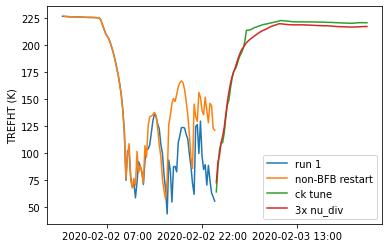

In [10]:
from matplotlib import pyplot
figure = pyplot.figure()
ax = figure.add_subplot(111)
for case in cases:
    data = data_arrays[case]
    minvals = data.min(dim=[d for d in data.dims if d != 'time']).values
    pl = ax.plot(data.time, minvals, label=case)
ax.set_ylabel(f'{varname} ({data.units})')
ax.legend()
figure.savefig(f'{varname}.time_series.png', bbox_inches='tight')

In [12]:
figure.savefig(f'{varname}.time_series.png', bbox_inches='tight', dpi=800)

In [9]:
import gzip
import numpy
from cartopy import crs
def parse_p3_warnings(file):
    
    # Read the gzip'd file lines
    try:
        lines = gzip.open(file, mode='rt').readlines()
    except:
        lines = open(file, mode='rt').readlines()
        
    # Work with just the P3 warning lines
    warning_lines = [l for l in lines if 'WARNING IN P3_MAIN -- src, gcol, lon, lat, lvl, tstep, T' in l]
    
    # Grab the stuff we are interested in
    columns = [float(l.split(',')[7]) for l in warning_lines]
    lon = [float(l.split(',')[8]) for l in warning_lines]
    lat = [float(l.split(',')[9]) for l in warning_lines]
    levels = [float(l.split(',')[10]) for l in warning_lines]
    nstep = [float(l.split(',')[11]) for l in warning_lines]
    temperature = [float(l.split(',')[12]) for l in warning_lines]

    # Check to make sure things are reasonable
    for i in range(len(warning_lines)):
        if temperature[i] < 0:
            print(warning_lines[i])
    
    return columns, lon, lat, levels, nstep, temperature


def parse_rrtmgp_warnings(file, vname='tint'):
    
    # Read the gzip'd file lines
    try:
        lines = gzip.open(file, mode='rt').readlines()
    except:
        lines = open(file, mode='rt').readlines()
        
    # Work with just the radiation warning lines
    warning_lines = [l for l in lines if 'WARNING IN RADIATION -- lon, lat, lev, {0}'.format(vname) in l]
    
    # Grab the stuff we are interested in
    lon = [float(l.split(':')[-1].split(',')[0]) for l in warning_lines]
    lat = [float(l.split(':')[-1].split(',')[1]) for l in warning_lines]
    levels = [float(l.split(':')[-1].split(',')[2]) for l in warning_lines]
    temperature = [l.split(':')[-1].split(',')[2] for l in warning_lines]
    
    return lon, lat, levels, temperature

# Define a distance function to help identify unique points
def distance(x, y):
    return numpy.sqrt(x**2.0 + y**2.0)


# Make list of just unique warnings
def get_unique_warning_points(files, tmin=150, tmax=370):
    # There's probably a better way of doing this with list comprehension
    ucol = []
    ulon = []
    ulat = []
    ulev = []
    ustep = []
    utemp = []
    for file in files:
        col, lon, lat, levels, nstep, temperature = parse_p3_warnings(file)
        for (c, x, y, z, n, t) in zip(col, lon, lat, levels, nstep, temperature):
            if len(ucol) == 0 or (all(distance(x - numpy.array(ulon), y - numpy.array(ulat)) > 3.0)):
                # Only look at cold points
                if t < tmin or t > tmax:
                    ucol.append(c)
                    ulon.append(x)
                    ulat.append(y)
                    ulev.append(z)
                    ustep.append(n)
                    utemp.append(t)
    # Return unique warnings points
    return ucol, ulon, ulat, ulev, ustep, utemp


def fix_lon(lon):
    return numpy.where(numpy.array(lon) > 180, numpy.array(lon) - 360, numpy.array(lon))


def plot_warning_locations(lon, lat, lev, temperature, color_temps=True, **kwargs):
    
    figure, ax = pyplot.subplots(1, 1, figsize=(15,5), subplot_kw=dict(projection=crs.PlateCarree()))
    ax.stock_img()

    for x, y, z, t in zip(lon, lat, lev, temperature):
        
        # Mark cold temperatures in blue, hot temperatures in red
        if color_temps:
            if t > 250:
                color = 'red'
            else:
                color = 'blue'
        else:
            color = 'black'
            
        # Mark warnings in upper atmosphere with up-triangle, warnings in lower atmosphere
        # with down-triangle, and all other warnings with a circle
        if z > 128 - 20:
            marker = 'v'
        elif z < 20:
            marker = '^'
        else:
            marker = 'o'
            
        pl = ax.plot(
            x, y, transform=crs.PlateCarree(), marker=marker, linestyle='none', 
            color=color, fillstyle='none', **kwargs
        )
        
    return figure

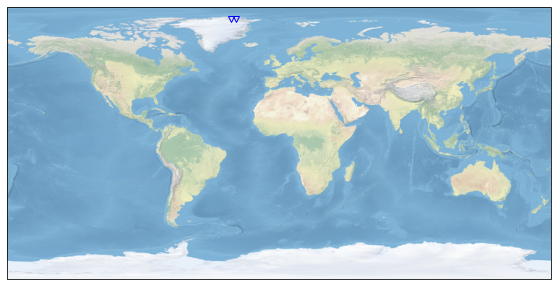

In [10]:
from matplotlib import pyplot
log_files = sorted(glob(f'{case_root}/run/e3sm.log.*'))
log_files
ucol, ulon, ulat, ulev, ustep, utemp = get_unique_warning_points(log_files, tmin=160, tmax=350)
figure = plot_warning_locations(ulon, ulat, ulev, utemp)

In [11]:
# How many warnings did we find in each file?
for file in log_files:
    col, lon, lat, levels, nstep, temperature = parse_p3_warnings(file)
    print('Found %i warnings'%len(col))

Found 0 warnings
Found 0 warnings
Found 0 warnings
Found 0 warnings
Found 0 warnings
Found 0 warnings
Found 0 warnings
Found 0 warnings
Found 43494 warnings


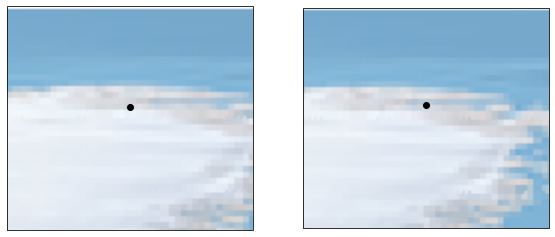

In [39]:
import math

# Show points on map, zoomed in on each to see if there are land masses around each
figure = pyplot.figure(figsize=(15, 10))
dx = 10
dy = 10
for i, (x, y) in enumerate(zip(fix_lon(ulon), ulat)):
    ax = figure.add_subplot(1, 3, i+1, projection=crs.PlateCarree(central_longitude=x))
    ax.stock_img()
    #ax.coastlines()
    pl = ax.plot(x, y, 'ko', transform=crs.PlateCarree())
    ax.set_extent([x-dx, x+dx, y-dy, y+dy], crs=crs.PlateCarree())

In [12]:
ulon

[328.4812, 331.7401]

In [13]:
ulat

[81.8443, 82.1033]

In [15]:
central_lon = (ulon[0] + ulon[1]) / 2.
central_lat = (ulat[0] + ulat[1]) / 2.
lons = central_lon - 5, central_lon + 5
lats = central_lat - 5, central_lat + 5
print(lons)
print(lats)

(325.11064999999996, 335.11064999999996)
(76.97380000000001, 86.97380000000001)


In [44]:
# Plot time series of mins and maxes around problem points
# Get global mins and maxes

# Regionally-subsetted
dx = 10
dy = 10
data_region = data.where(
    (ds.lon.data >  ulon[0] - dx) & 
    (ds.lon.data <= ulon[0] + dx) &
    (ds.lat.data >  ulat[0] - dy) &
    (ds.lat.data <= ulat[0] + dx)
).dropna(dim='ncol')

In [45]:
def plot_extrema(data, **kwargs):
    maxvals = data.max(dim=[d for d in data.dims if d != 'time']).values
    minvals = data.min(dim=[d for d in data.dims if d != 'time']).values
    ax = pyplot.gca()
    pl = ax.plot(data.time, minvals, linestyle='solid', **kwargs)
    pl = ax.plot(data.time, maxvals, linestyle='dashed', **kwargs)
    return pl

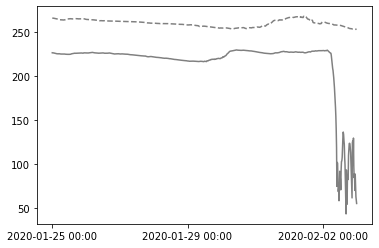

In [46]:
figure = pyplot.figure()
ax = figure.add_subplot(111)
pl = plot_extrema(data_region, color='0.5')

In [10]:
from e3smplot.e3sm_utils import get_scrip_grid_ds
scrip_grid = get_scrip_grid_ds(ds, grid_root='/global/cscratch1/sd/bhillma/grids')
ds_grid = xarray.open_dataset(scrip_grid)
x_corners = ds_grid.grid_corner_lon.rename({'grid_size': 'ncol'})
y_corners = ds_grid.grid_corner_lat.rename({'grid_size': 'ncol'})

In [7]:
from e3smplot.pyngl.plot_map import plot_map
import ngl
from IPython.display import Image
import os
plotname = f'{varname}_map.png'
wks = ngl.open_wks('png', os.path.splitext(plotname)[0])
pl = plot_map(
    wks, ds.lon.isel(time=-1).values, ds.lat.isel(time=-1).values, data.isel(time=-1).values, 
    mpGeophysicalLineColor='white',    
    lbOrientation='horizontal',   
    lbTitleString='%s (%s)'%(data.long_name, data.units),   
    cnFillMode='RasterFill',
    cnLineLabelsOn=False, cnLinesOn=False, #**kwargs
)
ngl.draw(pl)
ngl.end()
#Image(filename=plotname)

In [9]:
varname = 'SHFLX'
data = get_data(ds, varname)
plotname = f'{varname}_map.png'
wks = ngl.open_wks('png', os.path.splitext(plotname)[0])
pl = plot_map(
    wks, ds.lon.isel(time=-1).values, ds.lat.isel(time=-1).values, data.isel(time=-1).values, 
    mpGeophysicalLineColor='white',    
    lbOrientation='horizontal',   
    lbTitleString='%s (%s)'%(data.long_name, data.units),   
    cnFillMode='RasterFill',
    cnLineLabelsOn=False, cnLinesOn=False, #**kwargs
)
ngl.draw(pl)
ngl.end()
#Image(filename=plotname)

In [1]:
files

NameError: name 'files' is not defined